# Aggregate all of the Previous DataSets

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth, coord_flip, scale_color_manual
from sklearn.linear_model import LinearRegression as lm
import statsmodels.tools.tools as sm
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit
n
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)

Pull together all of the datasets cleaned

In [41]:
#awaiting Cook release of 2002 datapoints
#df108 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_108.csv")
df109 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_109.csv")
df110 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_110.csv")
df111 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_111.csv")
df112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_112.csv")
df113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_113.csv")
df114 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_114.csv")
df115 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_115.csv")
df116 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_116.csv")
df117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_117.csv")

NameError: name 'glob' is not defined

Concatonate and Touch Up

In [3]:
df = pd.concat([df109,df110,df111,df112,df113,df114,df115,df116,df117])
df["PVI"] = df["PVI"].str.replace("D+0","R+0")

Put into CSV for Later Use

In [4]:
df.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/aggregated_districts.csv", index = False)

In [5]:
#create pre-binned version for posterity
binned = df
binned["bin"] = pd.cut(binned['metric'], 
    bins = [0, .24, .42, .44, .45, .46, .47, .48, .49, .5,
    .51, .52, .53, .54, .57, .7, 1], labels =
    ["D+26+","D+25 to D+8","D+7 to D+6","D+5","D+4","D+3","D+2","D+1",
    "EVEN","R+1","R+2","R+3","R+4","R+5 to R+7","R+8 to R+20","R+21+"])
binned = binned.sort_values(by="metric")

In [6]:
#df = df[df["metric"] > .44]
#df = df[df["metric"] < .57]

In [7]:
#group by metric and average GOP seats
bm = df.groupby('metric').mean()
#bm = bm[bm['metric'] != 0.50]
#this will not be produced into a dataset without aggregating all years, as 
bm = bm.sort_values('metric')
bm = bm.reset_index()
bm = bm[bm.metric != .5]

In [8]:
#create a dataset where the metric is between 10% and 90% Republican
df_gop = df[df["metric"] > .5]
#df_gop = df_gop[df_gop["metric"] <= .71]
df_dem = df[df["metric"] < .5]
#df_dem = df_dem[df_dem["metric"] >= .38]

# Begin Split Probit

## Dem Probit

In [9]:
#group by metric and average GOP seats
bm_dem = df_dem.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_dem = bm_dem.sort_values('metric')
bm_dem = bm_dem.reset_index()

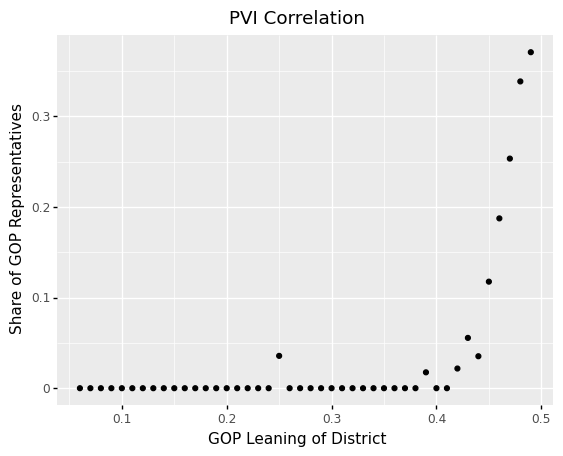

<ggplot: (8779152637672)>

In [10]:
#Plot averages
(p9.ggplot(data=bm_dem, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [11]:
#set input of GOP to a probit friendly format
df_dem.is_GOP = df_dem.is_GOP == 1
#define variables
Y = df_dem.is_GOP
X = df_dem.metric
model = Probit(Y, sm.add_constant(X).astype(float))
prob_mod = model.fit()
pred_Y = prob_mod.predict(sm.add_constant(X))
prob_mod.summary()

Optimization terminated successfully.
         Current function value: 0.143935
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 is_GOP   No. Observations:                 1724
Model:                         Probit   Df Residuals:                     1722
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:                  0.3251
Time:                        13:29:32   Log-Likelihood:                -248.14
converged:                       True   LL-Null:                       -367.69
Covariance Type:            nonrobust   LLR p-value:                 6.190e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9216      0.894    -11.103      0.000     -11.673      -8.170
metric        19.4382      1.966      9.887      0.000      15.585      23.292
==============================================================================

Possibly complete quasi-separation: A fraction 0.32 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

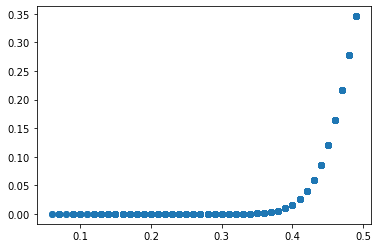

In [12]:
plt.scatter(X,pred_Y)

In [13]:
results = pd.concat([X,pred_Y], axis = 1)
#group by metric and average GOP seats
bm_dem_probit = results.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_dem_probit = bm_dem_probit.sort_values('metric')
bm_dem_probit = bm_dem_probit.reset_index()
bm_dem_probit[0] = bm_dem_probit[0].round(2)

## GOP Probit

In [14]:
#group by metric and average GOP seats
bm_gop = df_gop.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_gop = bm_gop.sort_values('metric')
bm_gop = bm_gop.reset_index()

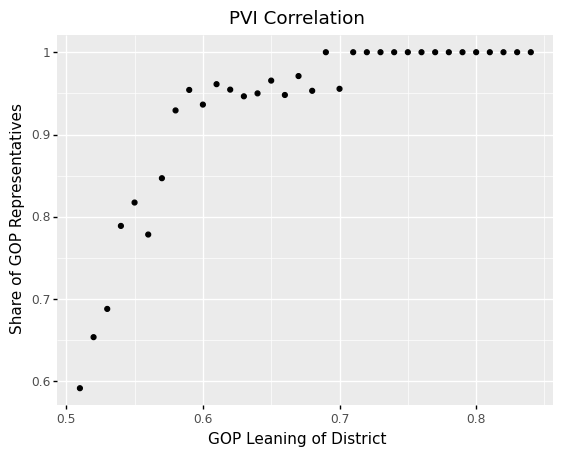

<ggplot: (8779120387413)>

In [15]:
#Plot averages
(p9.ggplot(data=bm_gop, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [16]:
#set input of GOP to a probit friendly format
df_gop.is_GOP = df_gop.is_GOP == 1
#define variables
Y = df_gop.is_GOP
X = df_gop.metric
model = Probit(Y, sm.add_constant(X).astype(float))
prob_mod = model.fit()
pred_Y = prob_mod.predict(sm.add_constant(X))
prob_mod.summary()

Optimization terminated successfully.
         Current function value: 0.307328
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 is_GOP   No. Observations:                 2109
Model:                         Probit   Df Residuals:                     2107
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:                  0.1557
Time:                        13:29:32   Log-Likelihood:                -648.16
converged:                       True   LL-Null:                       -767.69
Covariance Type:            nonrobust   LLR p-value:                 6.299e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1162      0.477    -10.728      0.000      -6.051      -4.181
metric        10.7774      0.833     12.931      0.000       9.144      12.411
==============================================================================
"""

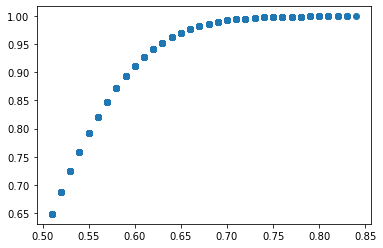

In [17]:
plt.scatter(X,pred_Y)

In [18]:
results = pd.concat([X,pred_Y], axis = 1)
#group by metric and average GOP seats
bm_gop_probit = results.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_gop_probit = bm_gop_probit.sort_values('metric')
bm_gop_probit = bm_gop_probit.reset_index()
bm_gop_probit[0] = bm_gop_probit[0].round(2)

# Conduct a split model with custom fits

Parameters [ 4.16719343e+01  4.98821435e-01 -9.39845222e-04]
RMSE: 0.012999896736137266
R-squared: 0.977138049443358


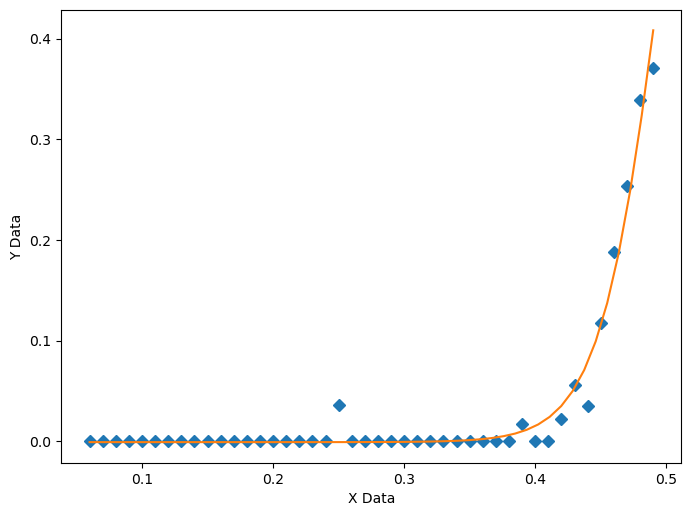

In [19]:
xdem = bm_dem.metric
ydem = bm_dem.is_GOP

def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xdem, *parameterTuple)
    return np.sum((ydem - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xdem)
    minX = min(xdem)
    maxY = max(ydem)
    minY = min(ydem)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset

    # "seed" the np random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters_dem, pcov = curve_fit(func, xdem, ydem, geneticParameters)

print('Parameters', fittedParameters_dem)

modelPredictions = func(xdem, *fittedParameters_dem) 

absError = modelPredictions - ydem

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(ydem))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

mpd = pd.DataFrame(modelPredictions)

def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xdem, ydem,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xdem), max(xdem))
    yModel = func(xModel, *fittedParameters_dem)

    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

Parameters [ 2.53555079e+01  4.94121915e-01 -5.44052030e-03]
RMSE: 0.020114597848006455
R-squared: 0.9649349042853923


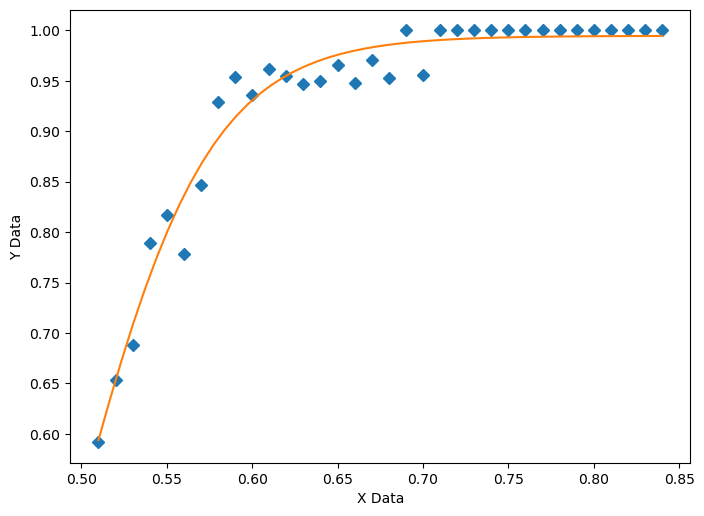

In [20]:
xgop = bm_gop.metric
ygop = bm_gop.is_GOP

def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xgop, *parameterTuple)
    return np.sum((ygop - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xgop)
    minX = min(xgop)
    maxY = max(ygop)
    minY = min(ygop)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset

    # "seed" the np random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters_gop, pcov = curve_fit(func, xgop, ygop, geneticParameters)

print('Parameters', fittedParameters_gop)

modelPredictions = func(xgop, *fittedParameters_gop) 

absError = modelPredictions - ygop

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(ygop))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

mpg = pd.DataFrame(modelPredictions)

def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xgop, ygop,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xgop), max(xgop))
    yModel = func(xModel, *fittedParameters_gop)

    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

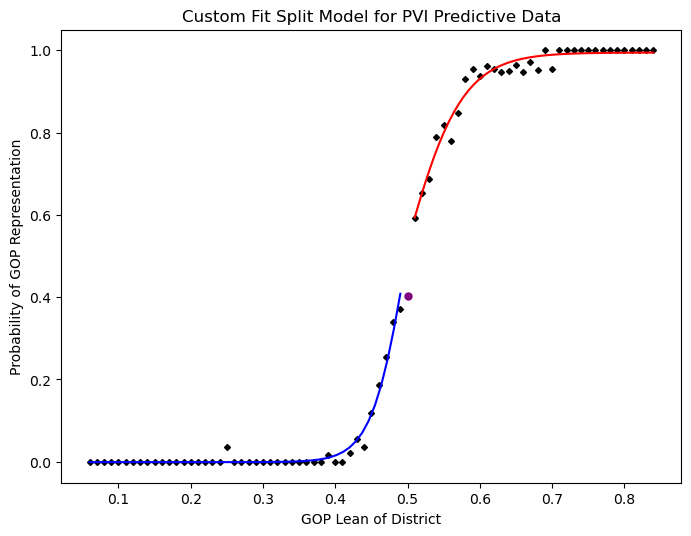

In [21]:
xData = bm.metric
yData = bm.is_GOP

def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D', markersize=3, markeredgecolor="black", markerfacecolor="black")

    # create data for the fitted equation plot
    xModel_gop = np.linspace(min(xgop), max(xgop))
    yModel_gop = func(xModel_gop, *fittedParameters_gop)
    xModel_dem = np.linspace(min(xdem), max(xdem))
    yModel_dem = func(xModel_dem, *fittedParameters_dem)

    # now the model as a line plot 
    axes.plot(xModel_dem, yModel_dem, color="blue")
    axes.plot(xModel_gop, yModel_gop, color="red")
    
    plt.plot([.5], [0.402439], marker="o", markersize=5, markeredgecolor="purple", markerfacecolor="purple")

    plt.title("Custom Fit Split Model for PVI Predictive Data")
    axes.set_xlabel('GOP Lean of District') # X axis data label
    axes.set_ylabel('Probability of GOP Representation') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [39]:
xModel_gop = np.linspace(min(xgop), max(xgop))
yModel_gop = func(xModel_gop, *fittedParameters_gop)
gop_xy_model = pd.DataFrame(xModel_gop,yModel_gop).reset_index()
gop_xy_model.columns = ["X","Y"]
xModel_dem = np.linspace(min(xdem), max(xdem))
yModel_dem = func(xModel_dem, *fittedParameters_dem)
dem_xy_model = pd.DataFrame(xModel_dem,yModel_dem).reset_index()
dem_xy_model.columns = ["X","Y"]

### Compare

In [ ]:
compare = bm
bm_split_probit = pd.concat([bm_dem_probit,bm_gop_probit]).reset_index(drop=True)
mp = pd.concat([mpd,mpg]).reset_index(drop=True)
compare["custom"] = mp
compare["probit"] = bm_split_probit[0]
compare.diff_prob = compare["is_GOP"] - compare["probit"]
compare.diff_cust = compare["is_GOP"] - compare["custom"]

In [ ]:
plt.scatter(compare.metric,compare.diff_prob)

This Scatterplot shows random, or at least more random, error than the previous models. Instead of a consistent "lambda" shape it is more scattered around the areas where prediction  is important

In [ ]:
plt.scatter(compare.metric,compare.diff_cust)

In [ ]:
compare

After excluding the EVEN districts, the 